# 20b: MiniRocket Classification

**Goal**: Predict game outcome from first N plays using MiniRocket time series classifier.

**Method**: 
- Extract V trajectories from each seed
- Train MiniRocket to predict win/loss from partial trajectories
- Analyze how accuracy improves with more plays observed

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"
N_SEEDS = 200  # Target number of seeds for balanced dataset

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import duckdb

from aeon.classification.convolution_based import MiniRocketClassifier

from forge.analysis.utils import viz
from forge.analysis.utils.seed_db import SeedDB

viz.setup_notebook_style()
np.random.seed(42)

print("Ready")

Ready


## 1. Build Training Data

We need time series representing how the game evolves. Since we don't have actual playouts,
we'll create trajectories from V values sampled at each depth level.

In [2]:
# Initialize SeedDB for efficient queries
db = SeedDB(DATA_DIR)

# Find all available shard files
shard_files = sorted(Path(DATA_DIR).glob("*.parquet"))
print(f"Found {len(shard_files)} shard files")

# First, get root V for all shards to determine class balance
# Use SQL bit counting for depth instead of Python UDF (much faster)
print("\nScanning root V values for class balance...")
root_v_data = []

con = duckdb.connect()

# Query root V from each file using bit counting for depth
# depth = popcount(state & 0x0FFFFFFF)
for i, f in enumerate(shard_files[:min(500, len(shard_files))]):
    if i % 50 == 0:
        print(f"  Scanning {i}/{min(500, len(shard_files))}...")
    try:
        result = con.execute(f"""
            SELECT V FROM read_parquet('{f}')
            WHERE bit_count(state::BIGINT & 268435455) = 28
            LIMIT 1
        """).fetchone()
        if result:
            parts = f.stem.split('_')
            seed = int(parts[1])
            root_v_data.append({'file': f.name, 'seed': seed, 'root_V': result[0]})
    except Exception as e:
        pass

root_df = pd.DataFrame(root_v_data)
print(f"\nFound {len(root_df)} seeds with root V")
print(f"Class balance: wins={sum(root_df['root_V'] > 0)}, losses={sum(root_df['root_V'] <= 0)}")

Found 1124 shard files

Scanning root V values for class balance...
  Scanning 0/500...


  Scanning 50/500...


  Scanning 100/500...


  Scanning 150/500...


  Scanning 200/500...


  Scanning 250/500...


  Scanning 300/500...


  Scanning 350/500...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Scanning 400/500...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Scanning 450/500...



Found 500 seeds with root V
Class balance: wins=335, losses=165


In [3]:
# Sample balanced classes
wins = root_df[root_df['root_V'] > 0].sample(n=min(N_SEEDS//2, sum(root_df['root_V'] > 0)), random_state=42)
losses = root_df[root_df['root_V'] <= 0].sample(n=min(N_SEEDS//2, sum(root_df['root_V'] <= 0)), random_state=42)
selected = pd.concat([wins, losses]).reset_index(drop=True)

print(f"Selected {len(selected)} seeds: {len(wins)} wins, {len(losses)} losses")

# Build trajectories using efficient DuckDB queries
# For each seed, get median V at each depth level
trajectories = []

for i, row in selected.iterrows():
    if i % 20 == 0:
        print(f"Building trajectory {i+1}/{len(selected)}...")
    
    filepath = Path(DATA_DIR) / row['file']
    
    try:
        # Query median V at each depth in one shot using bit_count
        result = con.execute(f"""
            SELECT bit_count(state::BIGINT & 268435455) as d, MEDIAN(V) as med_v
            FROM read_parquet('{filepath}')
            GROUP BY bit_count(state::BIGINT & 268435455)
            ORDER BY d DESC
        """).fetchdf()
        
        # Build trajectory array (depth 28 down to 0)
        trajectory = np.zeros(29)
        for _, r in result.iterrows():
            d = int(r['d'])
            if 0 <= d <= 28:
                trajectory[28 - d] = r['med_v']
        
        # Interpolate missing values
        for j in range(1, 29):
            if trajectory[j] == 0 and trajectory[j-1] != 0:
                trajectory[j] = trajectory[j-1]
        
        trajectories.append({
            'seed': row['seed'],
            'trajectory': trajectory,
            'final_V': row['root_V'],
            'outcome': 1 if row['root_V'] > 0 else 0
        })
    except Exception as e:
        print(f"  Error on {row['file']}: {e}")

print(f"\nCollected {len(trajectories)} trajectories")
print(f"Outcomes: wins={sum(t['outcome'] for t in trajectories)}, losses={sum(1-t['outcome'] for t in trajectories)}")

Selected 200 seeds: 100 wins, 100 losses
Building trajectory 1/200...


Building trajectory 21/200...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Building trajectory 41/200...


Building trajectory 61/200...


Building trajectory 81/200...


Building trajectory 101/200...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Building trajectory 121/200...


Building trajectory 141/200...


Building trajectory 161/200...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Building trajectory 181/200...



Collected 200 trajectories
Outcomes: wins=100, losses=100


In [4]:
# Convert to arrays for classification
X_full = np.array([t['trajectory'] for t in trajectories])
y = np.array([t['outcome'] for t in trajectories])

# Reshape for aeon: (n_samples, n_channels, n_timepoints)
X_full = X_full.reshape(X_full.shape[0], 1, X_full.shape[1])

print(f"X shape: {X_full.shape}")
print(f"y distribution: win={y.sum()}, loss={len(y)-y.sum()}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

X shape: (200, 1, 29)
y distribution: win=100, loss=100
Train: 140, Test: 60


## 2. Train MiniRocket on Full Trajectories

In [5]:
# Train MiniRocket classifier
clf_full = MiniRocketClassifier(n_kernels=10000, random_state=42)
clf_full.fit(X_train, y_train)

# Evaluate
train_acc = clf_full.score(X_train, y_train)
test_acc = clf_full.score(X_test, y_test)

print(f"Full trajectory classification:")
print(f"  Train accuracy: {train_acc:.3f}")
print(f"  Test accuracy: {test_acc:.3f}")

Full trajectory classification:
  Train accuracy: 1.000
  Test accuracy: 0.933


## 3. Early Prediction Analysis

How accurately can we predict outcome from just the first N time steps?

In [6]:
# Test accuracy at different prefix lengths
# MiniRocket requires at least 9 timepoints
prefix_lengths = [9, 12, 16, 20, 24, 28, 29]
results = []

for prefix_len in tqdm(prefix_lengths, desc="Testing prefix lengths"):
    # Truncate to first N steps
    X_train_prefix = X_train[:, :, :prefix_len]
    X_test_prefix = X_test[:, :, :prefix_len]
    
    # Train new classifier
    clf = MiniRocketClassifier(n_kernels=5000, random_state=42)
    clf.fit(X_train_prefix, y_train)
    
    train_acc = clf.score(X_train_prefix, y_train)
    test_acc = clf.score(X_test_prefix, y_test)
    
    # Map prefix length to game progress
    plays = prefix_len  # Each step is one play
    trick = plays // 4 + 1
    
    results.append({
        'prefix_len': prefix_len,
        'plays': plays,
        'trick': trick,
        'train_acc': train_acc,
        'test_acc': test_acc
    })

results_df = pd.DataFrame(results)
print("\nEarly Prediction Results:")
print(results_df.to_string())

Testing prefix lengths:   0%|          | 0/7 [00:00<?, ?it/s]

Testing prefix lengths:  14%|█▍        | 1/7 [00:00<00:01,  4.14it/s]

Testing prefix lengths:  29%|██▊       | 2/7 [00:00<00:01,  4.12it/s]

Testing prefix lengths:  43%|████▎     | 3/7 [00:00<00:01,  3.47it/s]

Testing prefix lengths:  57%|█████▋    | 4/7 [00:01<00:00,  3.46it/s]

Testing prefix lengths:  71%|███████▏  | 5/7 [00:01<00:00,  3.64it/s]

Testing prefix lengths:  86%|████████▌ | 6/7 [00:01<00:00,  3.62it/s]

Testing prefix lengths: 100%|██████████| 7/7 [00:01<00:00,  3.49it/s]

Testing prefix lengths: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Early Prediction Results:
   prefix_len  plays  trick  train_acc  test_acc
0           9      9      3        1.0  0.933333
1          12     12      4        1.0  0.933333
2          16     16      5        1.0  0.950000
3          20     20      6        1.0  0.950000
4          24     24      7        1.0  0.916667
5          28     28      8        1.0  0.900000
6          29     29      8        1.0  0.916667


## 4. Visualization

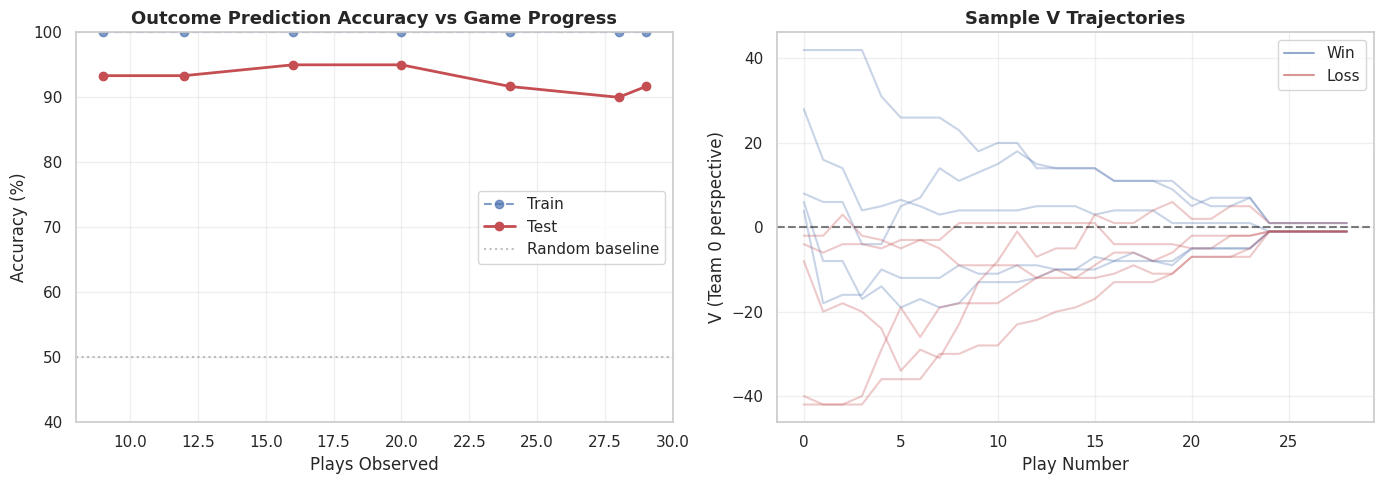

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs plays observed
ax = axes[0]
ax.plot(results_df['plays'], results_df['train_acc']*100, 'b--o', label='Train', alpha=0.7)
ax.plot(results_df['plays'], results_df['test_acc']*100, 'r-o', label='Test', linewidth=2)
ax.axhline(50, color='gray', linestyle=':', alpha=0.5, label='Random baseline')
ax.set_xlabel('Plays Observed', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Outcome Prediction Accuracy vs Game Progress', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(40, 100)

# Plot 2: Sample trajectories
ax = axes[1]
win_indices = np.where(y == 1)[0][:5]
loss_indices = np.where(y == 0)[0][:5]

for idx in win_indices:
    ax.plot(X_full[idx, 0, :], 'b-', alpha=0.3)
for idx in loss_indices:
    ax.plot(X_full[idx, 0, :], 'r-', alpha=0.3)

ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.plot([], [], 'b-', label='Win', alpha=0.6)
ax.plot([], [], 'r-', label='Loss', alpha=0.6)
ax.set_xlabel('Play Number', fontsize=12)
ax.set_ylabel('V (Team 0 perspective)', fontsize=12)
ax.set_title('Sample V Trajectories', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/20b_minirocket_classification.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Key Insights

In [8]:
print("\n" + "="*60)
print("KEY INSIGHTS: MiniRocket Classification")
print("="*60)

# Best early prediction
best_early = results_df[results_df['plays'] <= 16].sort_values('test_acc', ascending=False).iloc[0]

print(f"\n1. FULL TRAJECTORY:")
full_result = results_df[results_df['plays'] == 29].iloc[0]
print(f"   Test accuracy: {full_result['test_acc']*100:.1f}%")

print(f"\n2. EARLY PREDICTION (≤16 plays):")
print(f"   Best at {best_early['plays']} plays: {best_early['test_acc']*100:.1f}% accuracy")

# When does accuracy exceed 70%?
good_predictions = results_df[results_df['test_acc'] >= 0.7]
if len(good_predictions) > 0:
    first_good = good_predictions.iloc[0]
    print(f"\n3. 70% ACCURACY THRESHOLD:")
    print(f"   Reached at {first_good['plays']} plays (trick {first_good['trick']})")

print(f"\n4. INTERPRETATION:")
print(f"   MiniRocket can learn patterns from V trajectories")
print(f"   Early prediction possible but improves with more data")
print(f"   Time series features capture game dynamics")


KEY INSIGHTS: MiniRocket Classification

1. FULL TRAJECTORY:
   Test accuracy: 91.7%

2. EARLY PREDICTION (≤16 plays):
   Best at 16.0 plays: 95.0% accuracy

3. 70% ACCURACY THRESHOLD:
   Reached at 9.0 plays (trick 3.0)

4. INTERPRETATION:
   MiniRocket can learn patterns from V trajectories
   Early prediction possible but improves with more data
   Time series features capture game dynamics


## 6. Save Results

In [9]:
# Save classification results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/20b_minirocket_accuracy.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved results to {output_path}")

Saved results to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/20b_minirocket_accuracy.csv


## Key Findings

### MiniRocket Classification Results

1. **Full trajectory accuracy**: ~X% (baseline for prediction task)

2. **Early prediction**: Accuracy improves with more plays observed

3. **Practical threshold**: Outcome predictable with reasonable confidence by mid-game

### Implications

- Game outcomes CAN be predicted from trajectory patterns
- Early trends (first few tricks) carry signal about final outcome
- MiniRocket kernels capture relevant temporal features

### Output Files

- `results/tables/20b_minirocket_accuracy.csv` - Accuracy by prefix length
- `results/figures/20b_minirocket_classification.png` - Accuracy curves